In [13]:
import networkx as nx
import numpy as np
import torch

import os
import datetime
import shutil

import torch.optim as optimizer
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transf
from torchsummary import summary

import numpy as np
import pandas as pd
import random
from skimage import io
from data_feed import DataFeed_image_pos
import matplotlib.pyplot as plt

In [14]:
# year month day 
dayTime = datetime.datetime.now().strftime('%m-%d-%Y')
# Minutes and seconds 
hourTime = datetime.datetime.now().strftime('%H_%M')
print(dayTime + '\n' + hourTime)
dataset_dir = './image_beam/'
pwd = os.getcwd() + '//' + 'saved_folder' + '//' + dayTime + '_' + hourTime 
print(pwd)
# Determine whether the folder already exists
isExists = os.path.exists(pwd)
if not isExists:
    os.makedirs(pwd)    

12-31-2024
14_14
C:\Users\aghalkha21\Downloads\Git_Projects\Carla//saved_folder//12-31-2024_14_14


In [15]:
pos_path = "./pos_height_beam/scenario23_pos_height_beam.csv"
images_path = "./image_beam/scenario23_img_beam.csv"
pos_dataset = pd.read_csv(pos_path)
image_dataset = pd.read_csv(images_path)

In [16]:
pos_dataset.describe()

,index,unit2_lat,unit2_lon,unit2_height,unit2_distance,unit1_beam
count,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000
mean,5694.000000,0.342214,0.395211,0.318174,0.288409,15.227013
std,3287.288092,0.151951,0.115469,0.264798,0.169777,4.918251
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2847.500000,0.230261,0.342666,0.092153,0.173748,14.000000
50%,5694.000000,0.309431,0.410203,0.204380,0.238590,16.000000
75%,8540.500000,0.398631,0.448638,0.535584,0.368189,17.000000
max,11387.000000,1.000000,1.000000,1.000000,1.000000,30.000000


In [17]:
concat_data = pd.merge(pos_dataset, image_dataset, left_index=True, right_index=True)
concat_data = concat_data.drop(columns=["unit1_beam_y", "index_y"])

# Function to swap two columns
def swap_columns(df, col1, col2):
    cols = list(df.columns)
    idx1, idx2 = cols.index(col1), cols.index(col2)
    cols[idx1], cols[idx2] = cols[idx2], cols[idx1]
    return df[cols]

# Swap columns 'A' and 'C'
concat_data = swap_columns(concat_data, 'unit1_beam_x', 'unit1_rgb')

#concat_data = concat_data[["unit1_beam_x", "unit1_rgb"]]

In [18]:
concat_data.head()

,index_x,unit2_lat,unit2_lon,unit2_height,unit2_distance,unit1_rgb,unit1_beam_x
0,1,0.319556,0.487488,0.000000,0.087753,././datasets/scenario23_dev//unit1/camera_data...,22
1,2,0.317678,0.486797,0.002737,0.089964,././datasets/scenario23_dev//unit1/camera_data...,22
2,3,0.316038,0.486105,0.004562,0.092113,././datasets/scenario23_dev//unit1/camera_data...,22
3,4,0.314589,0.485414,0.009124,0.095125,././datasets/scenario23_dev//unit1/camera_data...,22
4,5,0.312354,0.484446,0.012774,0.097287,././datasets/scenario23_dev//unit1/camera_data...,20


In [19]:
modalities = ["pos_height", "images"]
num_users = 20
min_modality = 1
weights = [0.3, 0.5]

# Generate modality assignments
user_modalities = [
    list(set(random.choices(modalities, weights=weights, k=min_modality)
             + random.choices(modalities, weights=weights, k=1)))
    for _ in range(num_users)
]

# Output the result
for i, modalities_for_user in enumerate(user_modalities, 1):
    print(f"User {i}: {modalities_for_user}")


User 1: ['images', 'pos_height']
User 2: ['images', 'pos_height']
User 3: ['images', 'pos_height']
User 4: ['images']
User 5: ['images']
User 6: ['images', 'pos_height']
User 7: ['images', 'pos_height']
User 8: ['images', 'pos_height']
User 9: ['images', 'pos_height']
User 10: ['images', 'pos_height']
User 11: ['images', 'pos_height']
User 12: ['pos_height']
User 13: ['images']
User 14: ['images']
User 15: ['images', 'pos_height']
User 16: ['images']
User 17: ['images', 'pos_height']
User 18: ['images']
User 19: ['images']
User 20: ['images']


In [22]:
img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)

dataset = DataFeed_image_pos(data_csv=concat_data, transform=proc_pipe, modalities=["pos_height", "images"])

# Step 3: Test __len__
assert len(dataset) == 11387, f"Expected length 11387, got {len(dataset)}"

# Step 4: Test __getitem__
for idx in range(1):
    try:
        sample = dataset[idx]
        assert isinstance(sample, tuple), f"Expected tuple, got {type(sample)}"
        if "pos_height" in dataset.modalities:
            assert len(sample[0]) == 4, f"Expected 4 features, got {len(sample[0])}"
        if "images" in dataset.modalities:
            assert sample[1] is not None, f"Image is None at index {idx}"
        print(f"Sample {idx}: {sample}")
    except Exception as e:
        print(f"Error in sample {idx}: {e}")

# Step 5: Test modalities filtering
dataset.modalities = ["pos_height"]
sample = dataset[0]
assert len(sample) == 2, f"Expected 2 elements, got {len(sample)} (pos_height only)"

dataset.modalities = ["pos_height"]
sample = dataset[0]
assert len(sample) == 2, f"Expected 2 elements, got {len(sample)} (images only)"


# Step 6: Test DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
for _, (batch_idx, batch) in zip(range(1), enumerate(dataloader)):
    print(f"Batch {batch_idx}: {batch}")


Sample 0: (array([0.31955603, 0.4874879 , 0.        , 0.08775272], dtype=float32), tensor([[[-0.5596, -0.5424, -0.5424,  ...,  1.7694,  1.8379,  1.8893],
         [-0.5767, -0.5424, -0.5424,  ...,  1.7523,  1.8208,  1.8722],
         [-0.5767, -0.5424, -0.5424,  ...,  1.7180,  1.8037,  1.8722],
         ...,
         [-0.5938, -0.5938, -0.6109,  ..., -0.3541, -0.3541, -0.3541],
         [-0.5938, -0.5767, -0.5767,  ..., -0.3369, -0.3541, -0.3541],
         [-0.5767, -0.5767, -0.5938,  ..., -0.3369, -0.3541, -0.3541]],

        [[ 0.2927,  0.2927,  0.2752,  ...,  2.3585,  2.3761,  2.3936],
         [ 0.2927,  0.2752,  0.2752,  ...,  2.3410,  2.3761,  2.3936],
         [ 0.2927,  0.2927,  0.2752,  ...,  2.3410,  2.3936,  2.3936],
         ...,
         [ 0.3452,  0.3452,  0.3277,  ...,  0.4853,  0.4678,  0.4678],
         [ 0.3452,  0.3627,  0.3627,  ...,  0.4853,  0.4678,  0.4678],
         [ 0.3627,  0.3627,  0.3452,  ...,  0.4853,  0.4678,  0.4678]],

        [[ 1.1237,  1.1237,  1.10

In [23]:
import seaborn as sns

In [24]:
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11387 entries, 0 to 11386
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index_x         11387 non-null  int64  
 1   unit2_lat       11387 non-null  float64
 2   unit2_lon       11387 non-null  float64
 3   unit2_height    11387 non-null  float64
 4   unit2_distance  11387 non-null  float64
 5   unit1_rgb       11387 non-null  object 
 6   unit1_beam_x    11387 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 622.9+ KB


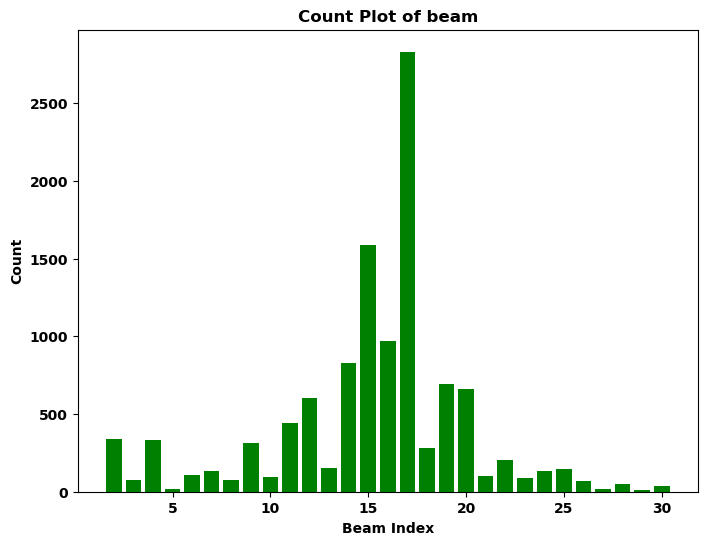

In [25]:
# univariate analysis using plots
df = concat_data
quality_counts = df["unit1_beam_x"].value_counts()

# using Matplotlib to create a count plot 
plt.figure(figsize=(8, 6)) #Figure size in inches
plt.bar(quality_counts.index, quality_counts, color='green')
plt.title("Count Plot of beam")
plt.xlabel("Beam Index")
plt.ylabel("Count")
plt.show()

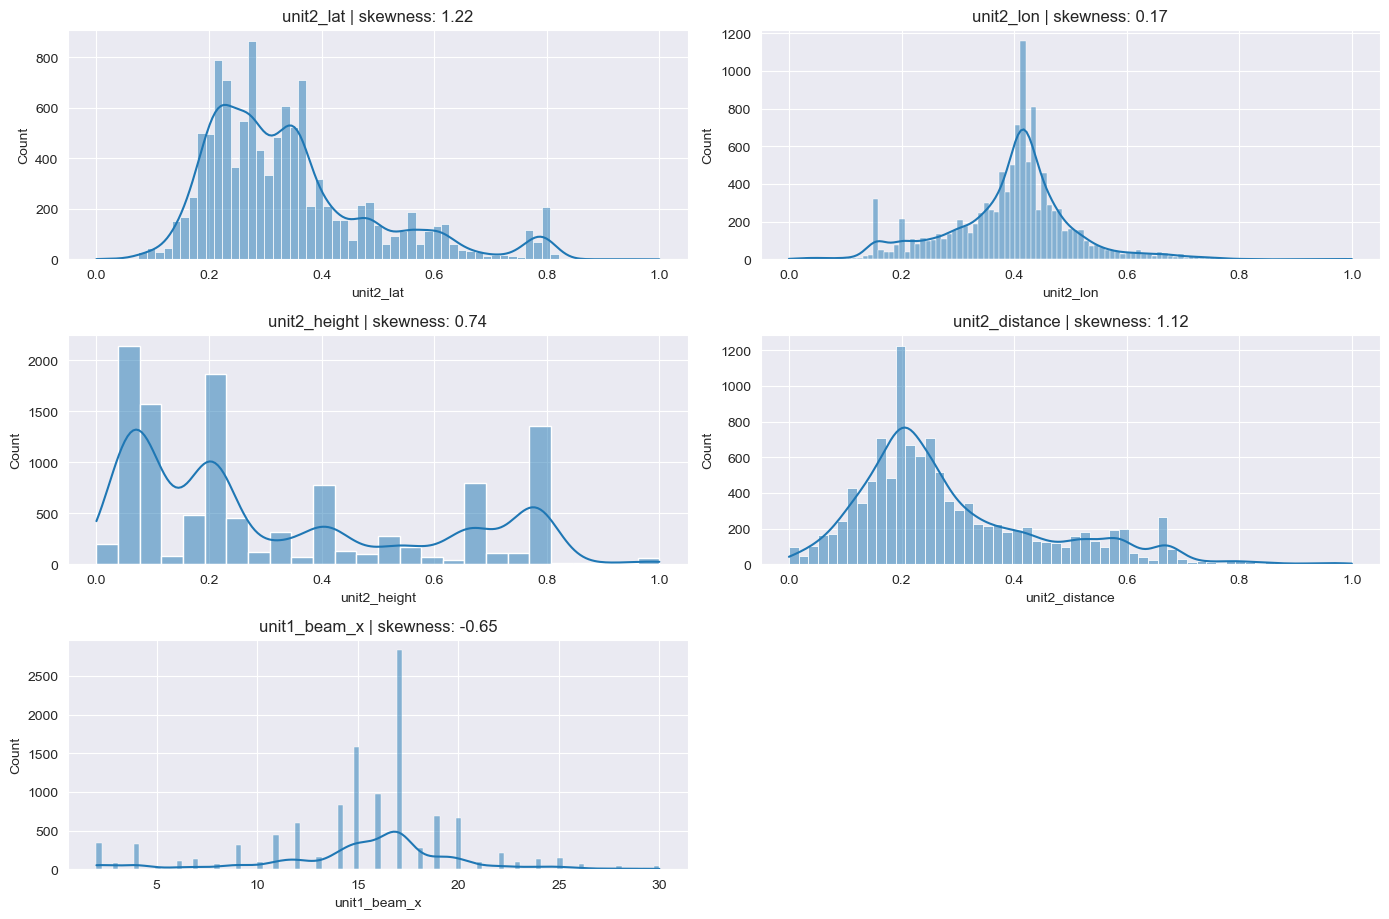

In [35]:
# Set seaborn style
sns.set_style("darkgrid")

# Identify numerical columns 
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns
numerical_columns = numerical_columns.drop("index_x")

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | skewness: {round(df[feature].skew(), 2)}")


# Adjust the layout and show plots 
plt.tight_layout()
plt.show()